In [1]:
pip install pandas numpy scikit-learn keras matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Trial 10 Complete [00h 00m 18s]
val_loss: 0.015572245232760906

Best val_loss So Far: 0.013938878662884235
Total elapsed time: 00h 03m 04s
Epoch 1/100


C:\Users\congc\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0095 - val_loss: 0.0139
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0138
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0136
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0142
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0136
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - val_loss: 0.0135
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0135
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - val_loss: 0.0134
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0135
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0133
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 - val_loss: 0.0130
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - val_l

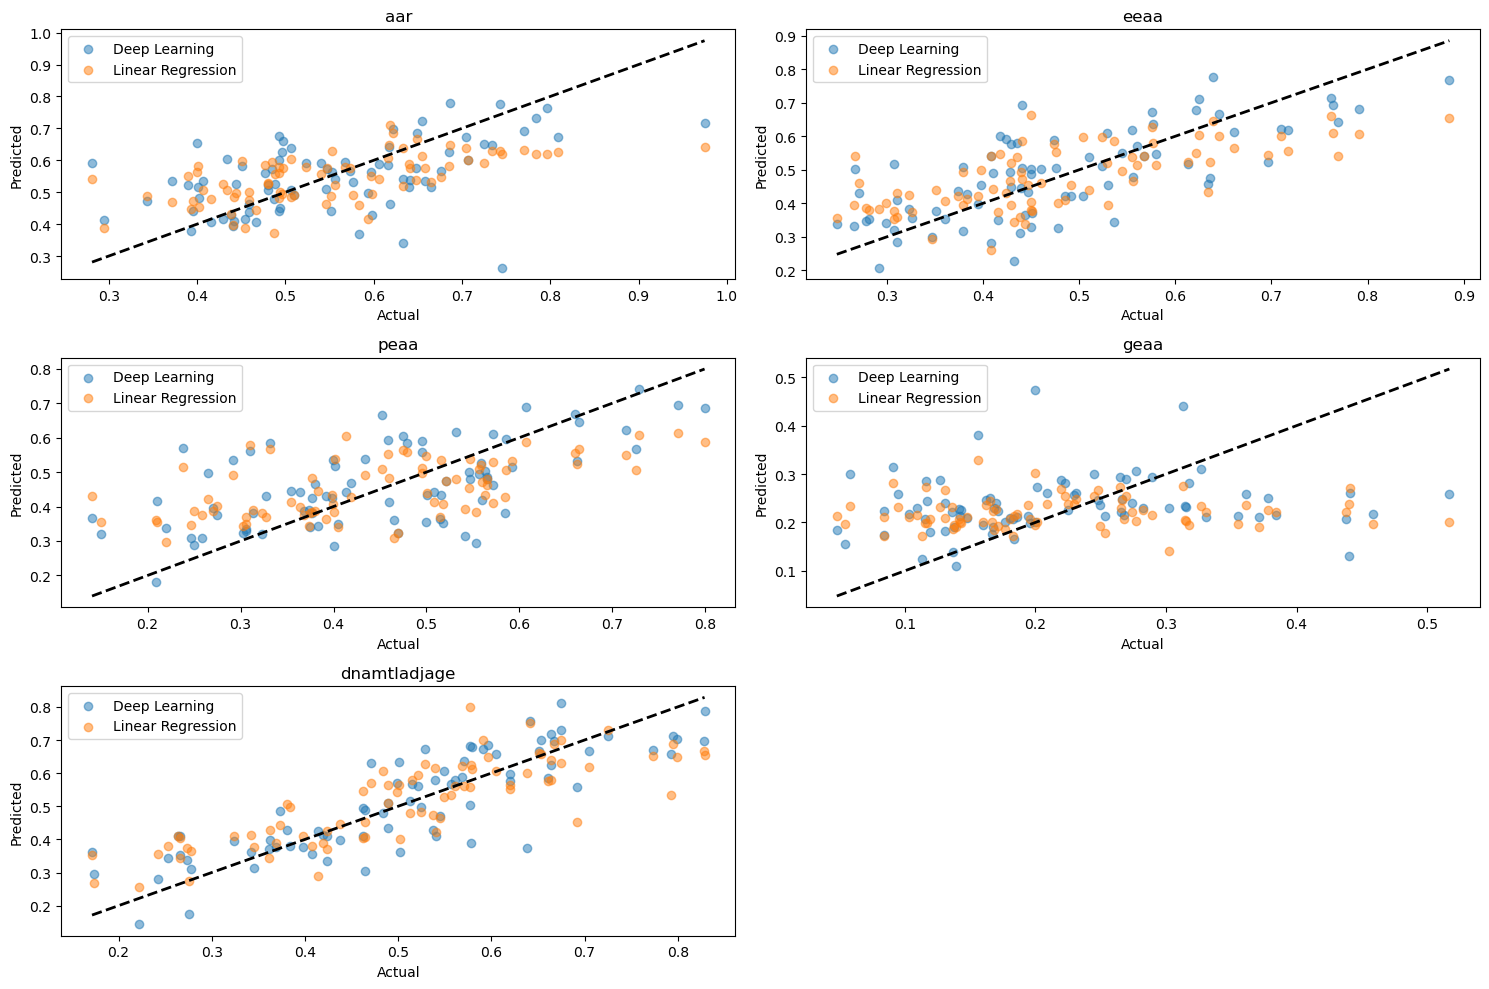

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from kerastuner import RandomSearch

# 加载数据集
df = pd.read_excel('NEW.xlsx')

# 选择特征和目标变量
X = df.iloc[:, [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 30, 31, 32, 33, 34, 35]].values
y = df[['aar', 'eeaa', 'peaa', 'geaa', 'dnamtladjage']].values

# 数据归一化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 分割数据集：80%训练集，10%验证集，10%测试集
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 定义模型构建函数
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(units=5))  # 输出层有5个单位
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 创建 Keras Tuner 实例
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)

# 开始超参数调优
tuner.search(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# 获取最佳模型
best_model = tuner.get_best_models(num_models=1)[0]

# 训练最佳模型
best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# 训练线性回归模型
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 预测
y_pred_dl = best_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

# 画出预测结果
plt.figure(figsize=(15, 10))
for i, col in enumerate(['aar', 'eeaa', 'peaa', 'geaa', 'dnamtladjage']):
    plt.subplot(3, 2, i + 1)
    plt.scatter(y_test[:, i], y_pred_dl[:, i], label='Deep Learning', alpha=0.5)
    plt.scatter(y_test[:, i], y_pred_lr[:, i], label='Linear Regression', alpha=0.5)
    plt.plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()], 'k--', lw=2)
    plt.title(col)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()

plt.tight_layout()
plt.show()


In [6]:
# 打印最佳超参数
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("最佳超参数:")
print(f"第一层单元数: {best_hyperparameters.get('units1')}")
print(f"第二层单元数: {best_hyperparameters.get('units2')}")


最佳超参数:
第一层单元数: 32
第二层单元数: 16


In [7]:
import sys
print(sys.version)



3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [8]:
import pkg_resources
installed_packages = pkg_resources.working_set
package_list = sorted(["%s==%s" % (i.key, i.version) for i in installed_packages])
print("\n".join(package_list))


-ensorflow-intel==2.15.0
absl-py==2.1.0
aext-assistant-server==4.0.15
aext-assistant==4.0.15
aext-core-server==4.0.15
aext-core==4.0.15
aext-panels-server==4.0.15
aext-panels==4.0.15
aext-share-notebook-server==4.0.15
aext-share-notebook==4.0.15
aext-shared==4.0.15
aiobotocore==2.4.2
aiofiles==22.1.0
aiohttp==3.8.3
aioitertools==0.7.1
aiosignal==1.2.0
aiosqlite==0.18.0
alabaster==0.7.12
anaconda-anon-usage==0.4.3
anaconda-catalogs==0.2.0
anaconda-client==1.12.0
anaconda-cloud-auth==0.5.1
anaconda-navigator==2.6.3
anaconda-project==0.11.1
anyio==3.5.0
appdirs==1.4.4
archspec==0.2.1
argon2-cffi-bindings==21.2.0
argon2-cffi==21.3.0
arrow==1.2.3
astroid==2.14.2
astropy==5.1
asttokens==2.0.5
astunparse==1.6.3
async-lru==2.0.4
async-timeout==4.0.2
atomicwrites==1.4.0
attrs==22.1.0
automat==20.2.0
autopep8==1.6.0
babel==2.11.0
backcall==0.2.0
backports.functools-lru-cache==1.6.4
backports.tempfile==1.0
backports.weakref==1.0.post1
basemap-data==1.3.2
basemap==1.4.1
bcrypt==3.2.0
beautifulsoup

In [9]:
import os
print(os.getcwd())


C:\Users\congc\Desktop\GENE PROJECT
